# k-Nearest Neighbors (kNN) 

## Exercises

### Import data

In [1]:
import pandas as pd
path_to_repo = '/Users/ruben/repo/personal/ga/DAT-23-NYC/'

#### Applying kNN

Let's look at the 538 polling data and see if we can use the census data to predict who was ahead in the polls, using kNN.

In [2]:
# Load data
poll_data = pd.read_csv(path_to_repo + 'data/538/2012_poll_data_states.csv', sep='\t')
census_data = pd.read_csv(path_to_repo + 'data/538/census_demographics.csv')
states = pd.read_csv(path_to_repo + 'data/538/states.csv')

In [3]:
# Join all the tables
census_w_polls = \
    census_data.merge(states, left_on='state', right_on='State_name') \
    .merge(poll_data, left_on='State_code', right_on='State')

In [4]:
print len(census_w_polls)
pd.options.display.max_columns = 35
census_w_polls.head(1)

767


,state,per_black,per_hisp,per_white,educ_hs,educ_coll,average_income,median_income,pop_density,vote_pop,older_pop,per_older,per_vote,State_name,State_code,Date,MoE,Obama (D),Poll,Romney (R),Sample,Spread,State
0,ARIZONA,4.5,30.1,57.4,85,26.3,25680,50448,56.3,3934880.535,920515.71,0.142,0.607,ARIZONA,AZ,9/15 - 9/26,--,43,RCP Average,48.7,--,Romney +5.7,AZ


In [5]:
# Select some features
features = ['per_black', 'per_hisp', 'per_white', 'educ_hs', 'educ_coll', 'pop_density', 'per_older', 'per_vote']
X = census_w_polls[features]
y = (census_w_polls['Obama (D)'] > census_w_polls['Romney (R)']).astype(int)

**Nota bene** 
- Please note that _X_ has a lot of duplicate rows, since we ommitted the date of the poll, but included all samples – and with different polling results. 
- Let's do the following questions for both the full dataset, and the dataset with unique rows

#### All dataset

- Initialize kNN, fit the model on all data, and compute the accuracy of your model.

In [6]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=10)
model.fit(X, y)
model.score(X, y)

0.80573663624511083

Wow, 80% accuracy! Seems great.

- Now use a training and test set for fit and test your model.
- How is its performance different?

In [7]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.72727272727272729

Note that `train_test_split` makes random splits, so your accuracy can be different than the one above, as you can see below:

In [8]:
import numpy as np
scores = []
for i in xrange(15):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8)
    scores.append(model.fit(X_train, y_train).score(X_test, y_test))
for score in scores:
    print np.round(score, 2),
print "\navg:", np.mean(scores)

0.77 0.79 0.73 0.79 0.81 0.73 0.77 0.79 0.8 0.8 0.81 0.77 0.77 0.86 0.8 
avg: 0.785281385281


So a lower accuracy, not still pretty good.

- Try a few different values for $k$ to see how your model changes

First, let's try in-sample data

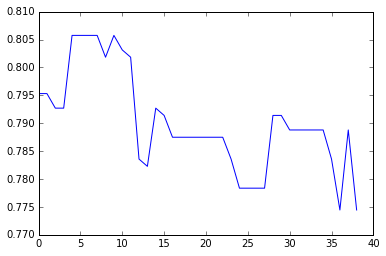

In [9]:
from matplotlib import pyplot as plt
%matplotlib inline

scores = []
for k in xrange(1, 40):
    scores.append(KNeighborsClassifier(n_neighbors=k).fit(X, y).score(X, y))
f = plt.plot(scores)

Hey, that is funny – we would expect an accuracy of 100% for $k=1$. This is because the dataset contains a lot of duplicate rows, so kNN behaves differently.

Now let's look at out-of-sample data.

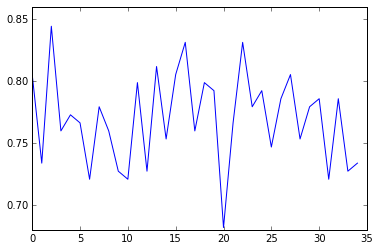

In [10]:
scores = []
for k in xrange(1, 36):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8)
    scores.append(KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train).score(X_test, y_test))
f = plt.plot(scores)

Crazy time. Let's look at the set without duplicates.

#### Dataset with only unique rows

Let's arbitrarily keep the first row of each duplicate.

In [11]:
X = X.drop_duplicates()
y = y.loc[X.index]
len(X)

45

We're only left with 45 states now. We might had gotten more states if we had done the merge better: maybe we have a few different keys for the same state. (I haven't closely looked at it.)

In [12]:
KNeighborsClassifier(n_neighbors=10).fit(X, y).score(X, y)

0.73333333333333328

73% - not as great as the earlier 80%, but still decent as a first result without putting too much thought in it.µm

In [13]:
import numpy as np
scores = []
for i in xrange(15):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8)
    scores.append(model.fit(X_train, y_train).score(X_test, y_test))
for score in scores:
    print np.round(score, 2),
print "\navg:", np.mean(scores)

0.89 0.78 0.89 0.78 0.67 0.56 0.67 0.56 0.56 0.56 0.67 0.44 0.22 0.67 0.67 
avg: 0.637037037037


Wow, these results are terrible! Also note that with a 80% training set, the remaining 20% test set only consists of 9 samples – which is why each accuracy is a fraction of nineths.

Let's plot the accuracy for varying $k$s for in-sample data.

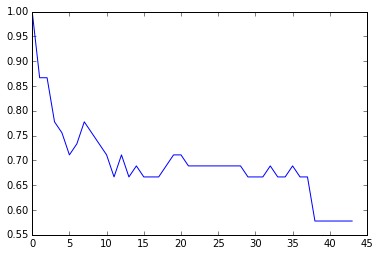

In [14]:
scores = []
for k in xrange(1, 45):
    scores.append(KNeighborsClassifier(n_neighbors=k).fit(X, y).score(X, y))
f = plt.plot(scores)

Nice, starts out at 100% as we expected for k=1, then descreases to the 70% level, which is the baseline of the naive "Obama-always-wins" classifier, and eventually drops even lower.

Now out-of-sample.

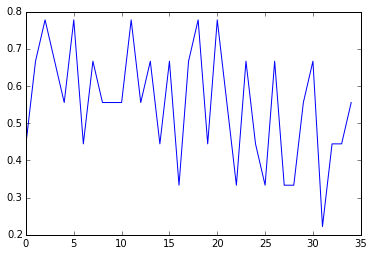

In [15]:
scores = []
for k in xrange(1, 36):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8)
    scores.append(KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train).score(X_test, y_test))
f = plt.plot(scores)

Crazy time: I think we have a pretty bad model for our data.

- Try removing features, or adding some other features and see how your model changes 

I am not going to do this, since this could require a lot of work and does not garantuee a success.

You could think of:
- better dedupe our data (not just first row, but most recent one, or all of the same time period)
- find a solution to incorporate the date field: maybe replace the custom string by a real timestamp, or just an ordinal number to indicate its position between other polls. (So polls closer in time are closer together for the kNN algorithm)
- Maybe adding median or average income to the features would help
- Maybe the `per_vote` column (% people voting) only adds noise and could better be removed 

Please be aware, though, that these features are not on the same scale (e.g., $$ income vs. % voters), so you might want to rescale the features as well. Even the features that are currenlty included, despite being all percentages, could be on an incomporable scale. We'll look at rescaling in the next lessons.

#### (*) Parameter optimization

Finding the best $k$ for your kNN-model is called _parameter optimization.

- (*) Take the iris dataset again, and plot the _in-sample_ accuracy of your model for all relevant $k$ (i.e., not using a training and test set, just using all data).

In [16]:
column_headers = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
data = pd.read_csv(path_to_repo + 'data/iris/iris.csv', header=None, names=column_headers)

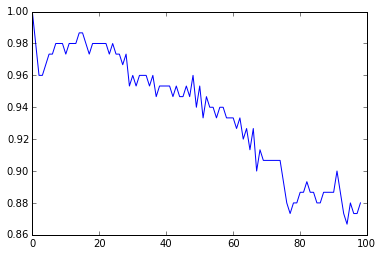

In [17]:
X, y = data[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']], data.species
scores = []
for k in xrange(1, 100):
    scores.append(KNeighborsClassifier(n_neighbors=k).fit(X, y).score(X, y))
f = plt.plot(scores)

- (*) Take the iris dataset again, and plot the cross-validated accuracy of your model for all relevant $k$.

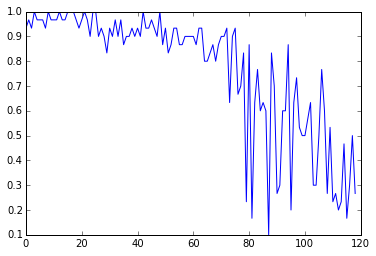

In [18]:
scores = []
for k in xrange(1, 120):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8)    
    scores.append(KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train).score(X_test, y_test))
f = plt.plot(scores)

You can imagine that using the test set to find your best $k$ poses the same _overfitting_ problem as we saw before: maybe we chose the $k$ only because it worked well for a specific test set. 
Best is therefore, to split up the dataset in a training set, an optimization set, and a test set, in say a 60-20-20 ratio.
- (**) Train your model on your training set, find the best $k$ using the optimization set, and use the test set to measure how good your model is.


In [19]:
# First take some test data out of your dataset
X_train_cv, X_test, y_train_cv, y_test = train_test_split(X, y, test_size=.2)

In [20]:
# Now optimize your model finding the best k
scores = {}
# Try a ton of different ks
for k in xrange(1, 50):
    scores[k] = []
    # Best is also to repeat this step a few times for each k, to average the random splits
    for i in xrange(20):
        # Taking 75% of 80% is 60% -- we now have 60% train, 20% cross-validation, 20% test
        X_train, X_cv, y_train, y_cv = train_test_split(X_train_cv, y_train_cv, train_size=.75)
        scores[k].append(KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train).score(X_cv, y_cv))
df = pd.DataFrame(scores)

We now have a dataframe with accuracies, with a column for each k and the bunch of repeated cross-validations in the rows.

In [21]:
df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,...,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,0.933333,1.000000,0.966667,0.900000,1.000000,0.933333,0.966667,0.933333,1.000000,0.933333,0.933333,0.966667,0.933333,0.900000,0.933333,0.933333,0.966667,...,0.900000,0.900000,0.966667,0.933333,0.800000,0.933333,0.866667,0.966667,0.833333,0.900000,0.866667,0.933333,0.933333,0.933333,0.866667,0.800000,0.633333
1,0.966667,1.000000,0.966667,1.000000,0.900000,0.966667,0.900000,0.933333,1.000000,1.000000,0.866667,0.866667,1.000000,0.933333,0.933333,0.933333,0.933333,...,0.866667,0.933333,0.900000,0.900000,0.833333,0.900000,0.900000,0.966667,0.866667,0.933333,0.633333,0.866667,0.900000,0.900000,0.933333,0.933333,0.833333
2,0.900000,0.966667,0.966667,0.933333,0.966667,0.966667,0.933333,0.933333,1.000000,0.933333,0.933333,0.900000,0.933333,0.933333,0.900000,0.933333,0.933333,...,0.966667,0.866667,0.933333,0.800000,0.866667,0.933333,0.933333,0.833333,0.933333,0.866667,0.933333,0.866667,0.833333,0.933333,0.800000,0.666667,0.900000
3,0.933333,0.933333,0.900000,1.000000,0.900000,0.966667,0.966667,0.933333,0.966667,0.966667,1.000000,1.000000,1.000000,0.966667,0.966667,0.966667,0.933333,...,0.933333,0.933333,0.966667,0.966667,0.933333,0.933333,0.933333,1.000000,0.900000,0.833333,0.933333,0.866667,0.766667,0.900000,0.666667,0.800000,1.000000
4,0.933333,0.933333,0.966667,0.966667,0.966667,0.966667,1.000000,0.933333,0.966667,0.866667,1.000000,0.933333,1.000000,0.866667,0.933333,0.966667,0.900000,...,0.866667,0.966667,0.833333,0.866667,0.933333,0.933333,0.800000,0.800000,0.900000,0.866667,0.866667,0.700000,0.866667,0.766667,0.933333,0.933333,0.766667


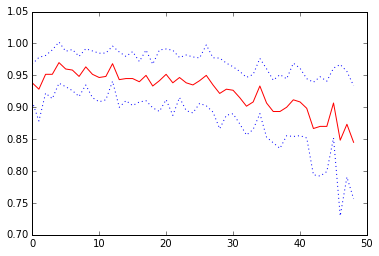

In [22]:
# Let's plot the averages, as well as the averages +/- the standard deviation, to get a sense of our results
mu, std = df.mean(), df.std()
plt.plot(mu + std, ':b')
plt.plot(mu - std, ':b')
f = plt.plot(mu, 'r')

I don't think it really matters what k we would pick exactly: anything between 5 and 15 looks reasonable.

In [23]:
# Let's take the one with the highest average accuracy
k = df.mean().argmax()
k

5

In [24]:
KNeighborsClassifier(n_neighbors=16).fit(X_train, y_train).score(X_test, y_test)

0.90000000000000002

90% accuracy – pretty awesome.

A better name for the optimization set is **cross-validation set**.

#### (**) Implementing kNN yourself

Goal of this exercise is to write the entire kNN algorithm yourself in python. This is a great exercise for those students who'd like to master the math *and* coding behind the algorithm.
- Please see the file `knn.py` in the course repo.
- Review the code. There are three methods that you need to complete: `fit`, `predict` and `score`.
- When you're done, you can check your work by running `$python knn_test.py` on the command line. 
- You can also run the code in this notebook below.
- Solutions are already given in `knn_solutions.py`

In [25]:
path_to_code = path_to_repo + '5_intro_to_ml/'

In [26]:
import sys, os
sys.path.append(path_to_code)
import knn_solutions as knn 
# import knn
reload(knn)

model = knn.kNN(k=15)
model.fit(X, y)
model.score(X, y)

0.98666666666666669